## Import the libraries

In [1]:
# For data handling and EDA
import pandas as pd
import numpy as np
# For Visualisation
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from wordcloud import STOPWORDS
# For NLP and ML
#import torch
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay, f1_score
from sklearn.svm import LinearSVC
#import nltk
import spacy
import keras
from keras.preprocessing.text import Tokenizer

#### Mounting Google Drive

In [2]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Colab_Notebooks
%ls /content/drive/MyDrive/Colab_Notebooks

Mounted at /content/drive
/content/drive/MyDrive/Colab_Notebooks
'Copy of cnn_sentence.ipynb'   hate-speech-dataset-master/
 data/                         Thesis_Project.ipynb


## Using the whole dataset

### Load the whole dataset to Pandas

In [ ]:
# Load the annotations metadata csv to get label info
annot = pd.read_csv("hate-speech-dataset-master/annotations_metadata.csv")
# Keep only file id and label
annot.drop(columns=['user_id','subforum_id','num_contexts'],inplace=True)
# Add new empty column to insert the message
annot['message']=''
# Loop through all lines
for i in range(len(annot['file_id'])):
    # Get current filename
    filename = annot['file_id'][i]
    # Open the file and read the contents
    with open('hate-speech-dataset-master/all_files/' +filename +'.txt') as f:
        contents= f.read()
    f.close()
    # Add contents to the message column
    annot['message'][i]=contents
# Drop file id
annot.drop(columns=['file_id'],inplace=True)

### EDA and Pre-Processing

In [ ]:
# DataFrame information
annot.info()

In [ ]:
# Check the classes and their value counts
annot['label'].value_counts()

Based on the original paper, there are a total of 10944 sentences, 9507 of them are classified as no hate speech, 1196 are classified as hate speech, 168 are related to hate speech but depends on content and 73 are non English sentences, classified as idk/skip. For the purpose of this research, relation and idk/skip classes will be dropped completely in order to make the problem a binary classification.

In [ ]:
# Keep sentences classified only as noHate and hate
cleanPosts = annot[(annot['label'] != 'relation') & (annot['label'] != 'idk/skip')]
# Reset index
cleanPosts=cleanPosts.reset_index(drop=True)

In [ ]:
# First 5 data points
cleanPosts.head(5)

In [ ]:
# Last 5 data points
cleanPosts.tail(5)

In [ ]:
# Update STOPWORDS
stop_words = STOPWORDS.update(["https", "S"])

In [ ]:
# WordCloud for posts classified as hate
wc_hate = WordCloud(stopwords=STOPWORDS, background_color='white').generate(' '.join(cleanPosts['message'][cleanPosts['label']=='hate']))
# Generate plot
plt.imshow(wc_hate)
plt.axis("off")
plt.show()

In [ ]:
# WordCloud for posts classified as noHate
wc_noHate = WordCloud(stopwords=STOPWORDS, background_color='white').generate(' '.join(cleanPosts['message'][cleanPosts['label']=='noHate']))
# Generate plot
plt.imshow(wc_noHate)
plt.axis("off")
plt.show()

### Recreating Paper Results

#### Pre-Process text with SpaCy

Before I proceed with the Bag of Words model, I need to pre-process the text (remove punctuations, stop words, lemmatize) in order to reduce the vocabulary size. I will use SpaCy for text pre-processing.

In [ ]:
# Get English words from NLTK
#nltk.download('words')
#words = set(nltk.corpus.words.words())
# Instantiate SpaCy's English module
nlp = spacy.load('en_core_web_sm')
# Remove default stop words and lemmatize each sentence
cleanPosts['clean_message'] = cleanPosts.message.apply(
    lambda text: 
        " ".join(
            token.lemma_.lower() for token in nlp(text)
                if token.lemma_.lower() not in nlp.Defaults.stop_words and token.is_alpha
                 #and token.lemma_.lower() in words
        )
)
# Drop old sentences
cleanPosts.drop(columns='message', inplace=True)

In [ ]:
# First 5 data points
cleanPosts.head(5)

In [ ]:
# Last 5 data points
cleanPosts.tail(5)

In [ ]:
# Check for empty strings and remove
cleanPosts[cleanPosts['clean_message'] == ''].count()

There are 233 empty entries after lemmatization and removing stop words, which I am going to remove.

In [ ]:
# Drop rows where 'clean_message' is an empty string
# Get index
idx = cleanPosts[cleanPosts['clean_message'] == ''].index
# Drop rows based on index
cleanPosts.drop(index=idx, inplace=True)

In [ ]:
# WordCloud for cleaned posts classified as hate
wc_hate_clean = WordCloud(stopwords=STOPWORDS, background_color='white').generate(' '.join(cleanPosts['clean_message'][cleanPosts['label']=='hate']))
# Generate plot
plt.imshow(wc_hate_clean)
plt.axis("off")
plt.show()

In [ ]:
# WordCloud for cleaned posts classified as noHate
wc_noHate_clean = WordCloud(stopwords=STOPWORDS, background_color='white').generate(' '.join(cleanPosts['clean_message'][cleanPosts['label']=='noHate']))
# Generate plot
plt.imshow(wc_noHate_clean)
plt.axis("off")
plt.show()

In [ ]:
# Plot the class distribution
plot = cleanPosts.label.value_counts().plot(kind='pie',autopct='%1.2f%%')

#### Bag-of-Words Vectors

In [ ]:
# Instantiate Count Vectorizer
vectorizer = CountVectorizer()
# Vectorize
X = vectorizer.fit_transform(cleanPosts.clean_message.to_list())
X_bow = pd.DataFrame(X.toarray(),columns=vectorizer.get_feature_names_out())

#### Split Dataset for SVM Model

In [ ]:
# Split dataset for training and testing
X_train, X_test, y_train, y_test = train_test_split(X_bow, cleanPosts.label, test_size=0.25, random_state=42, stratify=cleanPosts.label)

#### Classify text using SVM Model

Train the SVM Model

In [ ]:
# Instatiate SVC
svm = LinearSVC()
# Fit training data
svm.fit(X_train, y_train)
# Get prediction on test data
pred = svm.predict(X_test)

#### Get Accuracy and Confusion Matrix

In [ ]:
# Get the accuracy
print('Test Accuracy: '+str(svm.score(X_test, y_test)))
# Print the F1 Score
print('F1 Score: '+str(f1_score(y_test, pred, pos_label='hate')))
# Create confusion matrix
cm = confusion_matrix(y_test, pred, labels=svm.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm.classes_)
disp.plot()
plt.show()

Using all the available txt files with text pre-processing on a SVM Model returned an accuracy of 0.87 but an F1 Score of 0.48. This is because there is a big class inbalance in the training data. The SVM model does a really good job at classifying correctly the noHate sentences but handles poorly the hate sentences since more than half of them are missclassified.

## Using the sampled train and test dataset

### Load the provided sampled_train and sampled_test dataset from txt files.

In [ ]:
# Counter for missing text files
counter = 0
# Sampled Training Data
# Load the annotations metadata csv to get label info
annot_tr = pd.read_csv("hate-speech-dataset-master/annotations_metadata.csv")
# Keep only file id and label
annot_tr.drop(columns=['user_id','subforum_id','num_contexts'],inplace=True)
# Add new empty column to insert the message
annot_tr['message']=''
# Loop through all lines
for i in range(len(annot_tr['file_id'])):
    # Get current filename
    filename = annot_tr['file_id'][i]
    try:
        # Open the file and read the contents
        with open('hate-speech-dataset-master/sampled_train/' +filename +'.txt') as f:
            contents= f.read()
        f.close()
        # Add contents to the message column
        annot_tr['message'][i]=contents
    except:
        counter += 1
# Drop file id
annot_tr.drop(columns=['file_id'],inplace=True)

# Sampled Test Data
# Load the annotations metadata csv to get label info
annot_ts = pd.read_csv("hate-speech-dataset-master/annotations_metadata.csv")
# Keep only file id and label
annot_ts.drop(columns=['user_id','subforum_id','num_contexts'],inplace=True)
# Add new empty column to insert the message
annot_ts['message']=''
# Loop through all lines
for i in range(len(annot_ts['file_id'])):
    # Get current filename
    filename = annot_ts['file_id'][i]
    try:
        # Open the file and read the contents
        with open('hate-speech-dataset-master/sampled_test/' +filename +'.txt') as f:
            contents= f.read()
        f.close()
        # Add contents to the message column
        annot_ts['message'][i]=contents
    except:
        counter += 1
# Drop file id
annot_ts.drop(columns=['file_id'],inplace=True)

### EDA and Pre-Processing

In [11]:
# Keep sentences classified only as noHate and hate - Train Sample
cleanPosts_tr = annot_tr[(annot_tr['label'] != 'relation') & (annot_tr['label'] != 'idk/skip')]
# Reset index
cleanPosts_tr = cleanPosts_tr.reset_index(drop=True)

# Keep sentences classified only as noHate and hate - Test Sample
cleanPosts_ts = annot_ts[(annot_ts['label'] != 'relation') & (annot_ts['label'] != 'idk/skip')]
# Reset index
cleanPosts_ts = cleanPosts_ts.reset_index(drop=True)

#### WordCloud for Posts Classified as Hate

In [12]:
# Update STOPWORDS
stop_words = STOPWORDS.update(["https", "S"])

Train Sample

In [13]:
# WordCloud for posts classified as hate - Train Sample
wc_hate_tr = WordCloud(stopwords=STOPWORDS, background_color='white').generate(' '.join(cleanPosts_tr['message'][cleanPosts_tr['label']=='hate']))
# Generate plot
plt.imshow(wc_hate_tr)
plt.axis("off")
plt.show()

TypeError: ignored

Test Sample

In [ ]:
# WordCloud for posts classified as hate - Test Sample
wc_hate_ts = WordCloud(stopwords=STOPWORDS, background_color='white').generate(' '.join(cleanPosts_ts['message'][cleanPosts_ts['label']=='hate']))
# Generate plot
plt.imshow(wc_hate_ts)
plt.axis("off")
plt.show()

#### WordCloud for Posts Classified as noHate

Train Sample

In [ ]:
# WordCloud for posts classified as noHate - Train Sample
wc_noHate_tr = WordCloud(stopwords=STOPWORDS, background_color='white').generate(' '.join(cleanPosts_tr['message'][cleanPosts_tr['label']=='noHate']))
# Generate plot
plt.imshow(wc_noHate_tr)
plt.axis("off")
plt.show()

Test Sample

In [ ]:
# WordCloud for posts classified as noHate - Test Sample
wc_noHate_ts = WordCloud(stopwords=STOPWORDS, background_color='white').generate(' '.join(cleanPosts_ts['message'][cleanPosts_ts['label']=='noHate']))
# Generate plot
plt.imshow(wc_noHate_ts)
plt.axis("off")
plt.show()

### Recreating Paper Results

#### Pre-Process text with SpaCy

Train Sample

In [7]:
# Instantiate SpaCy's English module - Train Sample
nlp = spacy.load('en_core_web_sm')
# Remove default stop words and lemmatize each sentence
cleanPosts_tr['clean_message'] = cleanPosts_tr.message.apply(
    lambda text: 
        " ".join(
            token.lemma_.lower() for token in nlp(text)
                if token.lemma_.lower() not in nlp.Defaults.stop_words and token.is_alpha
        )
)
# Drop old sentences
cleanPosts_tr.drop(columns='message', inplace=True)

ValueError: ignored

Test Sample

In [ ]:
# Instantiate SpaCy's English module - Test Sample
nlp = spacy.load('en_core_web_sm')
# Remove default stop words and lemmatize each sentence
cleanPosts_ts['clean_message'] = cleanPosts_ts.message.apply(
    lambda text: 
        " ".join(
            token.lemma_.lower() for token in nlp(text)
                if token.lemma_.lower() not in nlp.Defaults.stop_words and token.is_alpha
        )
)
# Drop old sentences
cleanPosts_ts.drop(columns='message', inplace=True)

#### Drop rows with empty strings

Train Sample

In [14]:
# Drop rows where 'clean_message' is an empty string - Train Sample
# Get index
idx = cleanPosts_tr[cleanPosts_tr['clean_message'] == ''].index
# Drop rows based on index
cleanPosts_tr.drop(index=idx, inplace=True)

KeyError: ignored

Test Sample

In [ ]:
# Drop rows where 'clean_message' is an empty string - Train Sample
# Get index
idx = cleanPosts_ts[cleanPosts_ts['clean_message'] == ''].index
# Drop rows based on index
cleanPosts_ts.drop(index=idx, inplace=True)

### Load cleanPosts_tr and cleanPosts_tr from csv file (for Google Colab only).

In [3]:
# Load cleanPosts_tr
cleanPosts_tr = pd.read_csv('hate-speech-dataset-master/cleanPosts_tr.csv')

# Load cleanPosts_ts
cleanPosts_ts = pd.read_csv('hate-speech-dataset-master/cleanPosts_ts.csv')

#### Plot class distribution

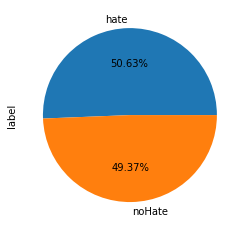

In [4]:
# Plot the class distribution - Train
plot_tr = cleanPosts_tr.label.value_counts().plot(kind='pie',autopct='%1.2f%%')

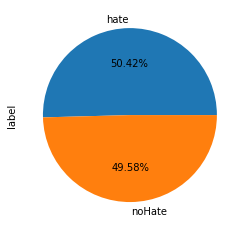

In [5]:
# Plot the class distribution - Test
plot_ts = cleanPosts_ts.label.value_counts().plot(kind='pie',autopct='%1.2f%%')

#### Combine train and test samples into one pandas DataFrame

In [6]:
# Combine the train and test samples to use for the BoW vocabulary
cleanPosts_cb = pd.concat([cleanPosts_tr, cleanPosts_ts])

#### Bag-of-Words Vectors

In [ ]:
# Instantiate Count Vectorizer
vectorizer = CountVectorizer()
# Create the vocabulary
vectorizer.fit(cleanPosts_cb.clean_message.to_list())

# Transform train sample to document-term matrix
X_tr = vectorizer.transform(cleanPosts_tr.clean_message.to_list())
# Create a dataframe from the document-term matrix
X_train_b = pd.DataFrame(X_tr.toarray(),columns=vectorizer.get_feature_names_out())

# Transform test sample to document-term matrix
X_ts = vectorizer.transform(cleanPosts_ts.clean_message.to_list())
# Create a dataframe from the document-term matrix
X_test_b = pd.DataFrame(X_ts.toarray(),columns=vectorizer.get_feature_names_out())

#### Classify text using the SVM Model

Train the SVM Model

In [ ]:
# Instatiate SVC
svm = LinearSVC()
# Fit training data
svm.fit(X_train_b, cleanPosts_tr.label)
# Get prediction on test data
pred = svm.predict(X_test_b)

#### Get Accuracy, F1 Score and Confusion Matrix

In [ ]:
# Print the accuracy
print('Accuracy: '+str(svm.score(X_test_b, cleanPosts_ts.label)))
# Print the F1 Score
print('F1 Score: '+str(f1_score(cleanPosts_ts.label, pred, pos_label='hate')))
# Create confusion matrix
cm = confusion_matrix(cleanPosts_ts.label, pred, labels=svm.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm.classes_)
disp.plot()
plt.show()

Using the sampled train and test data returned an accuracy of 0.74, which is lower than the accuracy I got using the whole dataset. However, the F1 Score is much higher, 0.74, and the model does a fair job in correctly classifying both hate and noHate classes. These results are very close to the results from the paper and indicate the importance of having a class balaned dataset when it comes to text classification. For the rest of this research, the balanced train and test datasets will be used.

#### Classify text using CNN Model

The Hate Speech Dataset paper provides the link for the code used for the CNN model. The code below was downloaded from https://github.com/dennybritz/cnn-text-classification-tf and https://github.com/lubiluk/cnn-sentence. 

#### Prepare the dataset
1) Tokenize the text into number sequences
2) Pad sequences to the same length (of the longest sequence)
3) One hot encode train and test labels

In [7]:
# Code from notebook provided in https://github.com/lubiluk/cnn-sentence
# Build the vocabulary
max_document_length = max([len(x.split(" ")) for x in cleanPosts_cb.clean_message.to_list()])
# Tokenizer default filtering seems to be identical to original clean_str
tokenizer = Tokenizer()
# Fit vocabulary using both train and test
tokenizer.fit_on_texts(cleanPosts_cb.clean_message.to_list())

# Convert train to sequences
x_train_cnn = np.array(tokenizer.texts_to_sequences(cleanPosts_tr.clean_message.to_list()), dtype='object')
# Pad examples to the same length
x_train_cnn = keras.preprocessing.sequence.pad_sequences(x_train_cnn,
                                               value=0,
                                               padding='post',
                                               maxlen=max_document_length)

# Convert test to sequences
x_test_cnn = np.array(tokenizer.texts_to_sequences(cleanPosts_ts.clean_message.to_list()), dtype='object')
# Pad examples to the same length
x_test_cnn = keras.preprocessing.sequence.pad_sequences(x_test_cnn,
                                               value=0,
                                               padding='post',
                                               maxlen=max_document_length)

# one hot encode train labels
y_train_cnn = pd.get_dummies(cleanPosts_tr.label).astype('int32').values

# one hot encode test labels
y_test_cnn = pd.get_dummies(cleanPosts_ts.label).astype('int32').values

#### Set up hyperparameters

In [8]:
# Percentage of the training data to use for validation
dev_sample_percentage = 0.1
# Dimensionality of character embedding (default: 128)
embedding_dim = 128
# Filter sizes (default: [3, 4, 5])
filter_sizes = [3, 4, 5]
# Number of filters per filter size (default: 128)
num_filters = 128
# L2 regularization lambda (default: 0.0) (unused)
l2_reg_lambda = 0.0
# Dropout keep probability (default: 0.5)
dropout_keep_prob = 0.5
# Batch Size (default: 64)
batch_size = 64
# Number of training epochs (default: 200)
num_epochs = 100

#### Build the model

In [10]:
# Build the model
sequence_length = x_train_cnn.shape[1]
num_classes = y_train_cnn.shape[1]
vocab_size = len(tokenizer.word_index) + 1
embedding_size = embedding_dim

print("Sequence Length: {}".format(sequence_length))
print("Number of Classes: {}".format(num_classes))
print("Vocabulary Size: {}".format(vocab_size))
print("Embedding Size: {}".format(embedding_size))

inputs = keras.layers.Input(shape=(sequence_length,))
x = keras.layers.Embedding(vocab_size, embedding_size, input_length=sequence_length,
                          embeddings_initializer='random_uniform')(inputs)
x = keras.layers.Reshape((sequence_length, embedding_size, 1))(x)

filter_layers = []

for s in filter_sizes:
  f = keras.layers.Conv2D(
      num_filters, kernel_size=(s, embedding_size), strides=(1, 1),
      padding='valid', data_format='channels_last', activation='relu',
      use_bias=True, kernel_initializer=keras.initializers.TruncatedNormal(stddev=0.01),
      bias_initializer=keras.initializers.Constant(value=0.1))(x)
  f = keras.layers.MaxPooling2D(pool_size=(sequence_length - s + 1, 1), strides=(1, 1), padding='valid', data_format='channels_last')(f)
  filter_layers.append(f)

# Combine all the pooled features
x = keras.layers.concatenate(filter_layers, axis=1)
x = keras.layers.Reshape((num_filters * len(filter_sizes), ))(x)

# Add dropout
x = keras.layers.Dropout(dropout_keep_prob)(x)

# Final (unnormalized) scores and predictions
predictions = keras.layers.Dense(num_classes, use_bias=True, 
                                 bias_initializer=keras.initializers.Constant(value=0.1),
                                 kernel_initializer=keras.initializers.glorot_uniform(seed=None),
                                 kernel_regularizer=keras.regularizers.l2(l2_reg_lambda), 
                                 bias_regularizer=keras.regularizers.l2(l2_reg_lambda),
                                 activation='softmax')(x)
  
model = keras.Model(inputs=inputs, outputs=predictions)
model.summary()

Sequence Length: 122
Number of Classes: 2
Vocabulary Size: 5132
Embedding Size: 128
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 122)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 122, 128)     656896      ['input_1[0][0]']                
                                                                                                  
 reshape (Reshape)              (None, 122, 128, 1)  0           ['embedding[0][0]']              
                                                                                                  
 conv2d (Conv2D)                (None, 120, 1, 128)  49280       ['reshape[0][0]']                
          

#### Visualise the CNN Model

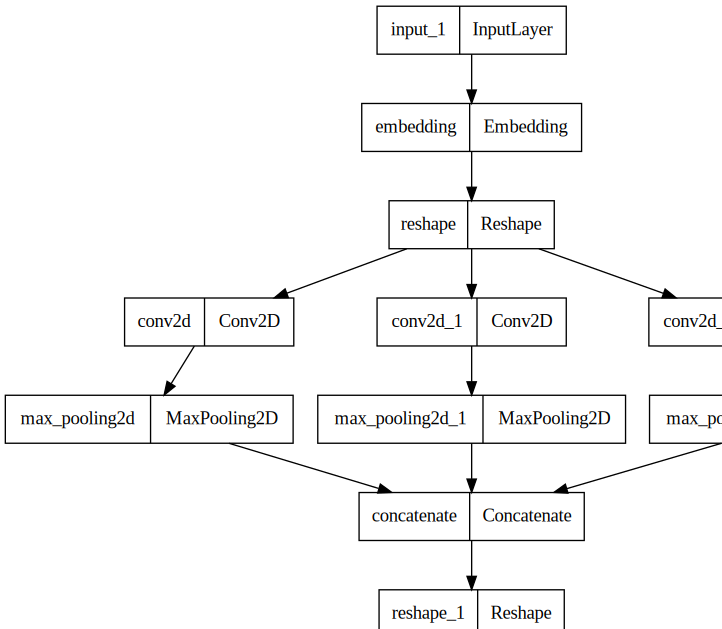

In [11]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

#### Prepare the training process

In [12]:
# Specify loss function and optimizer
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

#### Train the CNN Model

In [13]:
history = model.fit(x_train_cnn,
                    y_train_cnn,
                    epochs=num_epochs,
                    batch_size=batch_size,
                    validation_split=dev_sample_percentage,
                    verbose=1)

Epoch 1/50
54/54 [==============================] - 19s 308ms/step - loss: 0.6387 - acc: 0.6143 - val_loss: 0.5954 - val_acc: 0.6825
Epoch 2/50
54/54 [==============================] - 11s 199ms/step - loss: 0.4042 - acc: 0.8460 - val_loss: 0.5833 - val_acc: 0.7302
Epoch 3/50
54/54 [==============================] - 9s 160ms/step - loss: 0.1811 - acc: 0.9383 - val_loss: 0.6363 - val_acc: 0.7460
Epoch 4/50
54/54 [==============================] - 9s 161ms/step - loss: 0.0733 - acc: 0.9782 - val_loss: 0.7797 - val_acc: 0.6825
Epoch 5/50
54/54 [==============================] - 9s 160ms/step - loss: 0.0338 - acc: 0.9924 - val_loss: 0.9583 - val_acc: 0.6667
Epoch 6/50
54/54 [==============================] - 9s 159ms/step - loss: 0.0176 - acc: 0.9976 - val_loss: 1.0463 - val_acc: 0.6614
Epoch 7/50
54/54 [==============================] - 9s 161ms/step - loss: 0.0099 - acc: 0.9988 - val_loss: 1.1312 - val_acc: 0.6667
Epoch 8/50
54/54 [==============================] - 9s 160ms/step - loss: 

#### Plot the training history

Training and validation loss.

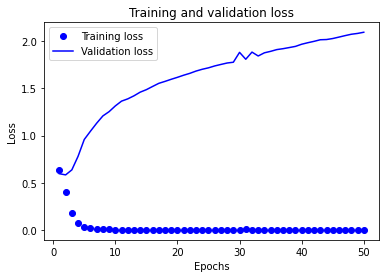

In [14]:
history_dict = history.history

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Training and validation accuracy.

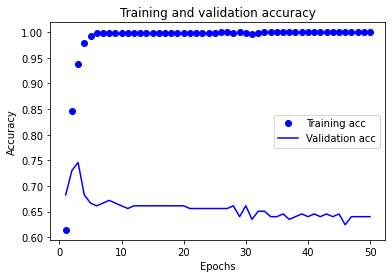

In [15]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#### Test the CNN model
Test the model on the sampled test data. Print the Accuracy, F1 Score and Confusion Matrix

In [25]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(x_test_cnn, y_test_cnn)
print("test loss, test acc:", results)
pred = model.predict(x_test_cnn)

Evaluate on test data
15/15 [==============================] - 1s 46ms/step - loss: 1.7622 - acc: 0.7246
test loss, test acc: [1.7621996402740479, 0.7245762944221497]


F1 Score: 0.7325102880658436


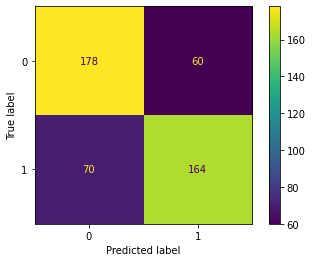

In [54]:
# Convert pred to boolean
y_pred_bool = np.argmax(pred, axis=1)

# Convert categorical label to numeric
y_test_cnn = cleanPosts_ts.label.replace(['hate','noHate'],[0,1])

# Get F1 Score and Confusion Matrix
# Print the F1 Score
print('F1 Score: '+str(f1_score(y_test_cnn, y_pred_bool, pos_label=0)))
# Create confusion matrix
cm = confusion_matrix(y_test_cnn, y_pred_bool)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()